In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns
from itertools import product

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seml/database.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
collection_name = 'week11_normalizing_flows'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    with open(ex['result']) as f:
        ex['result'] = json.load(f)

print(f'Number of finished experiments : {len(experiments)}')

Number of finished experiments : 8


In [87]:
SETTING = 'Setting'
RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Normalzation'
NORMALIZE_OUTPUT = 'Spectral Output Normalization'
ACCURACY = 'Accuracy'
ECE = 'Expected Calibration Error'
WEIGHT_SCALE = 'Weight Scale'
LIPSCHITZ = 'Median Empirical Lipschitz Constant'
LIPSCHITZ_MAX = 'Max Empirical Lipschitz Constant'
OOD = 'Out of Distribution Setting'
PROXY = 'Proxy'
LOC = 'LoC'
BERNOULLI = 'Bernoulli'
NORMAL = 'Normal'
GPC = 'Feature Density GPC'
MAX_SCORE = 'Max Softmax Score'
AUROC = 'AUC-ROC'
TRANSDUCTIVE = 'Transductive'
HYBRID = 'Hybrid'
NO_EDGES = 'Remove Edges'
PROXY_PARAMS = 'Parameters'
PROXY_MODE = 'Proxy Mode'

In [112]:
data = []
for ex in experiments:
    for idx in range(ex['config']['data']['num_dataset_splits'] * ex['config']['model']['num_initializations']):
        base = {
                SETTING : HYBRID if ex['config']['data']['train_labels_remove_other'] else TRANSDUCTIVE,
                RESIDUAL : ex['config']['model']['residual'],
                SPECTRAL_NORM : ex['config']['model']['use_spectral_norm'],
                WEIGHT_SCALE : (ex['config']['model']['weight_scale']),
                LIPSCHITZ : ex['result']['empirical_lipschitz_val_slope_median_perturbation_noise-perturbations'][idx],
                LIPSCHITZ_MAX : ex['result']['empirical_lipschitz_val_slope_max_perturbation_noise-perturbations'][idx],
            }
        for k, values in ex['result'].items():
            if 'auroc' in k:
                k = k.replace(':no', '') # Ignore dim reduction
                k = k.replace('auroc_', '')
                if '-no-edges' in k:
                    no_edges = True
                    k = k.replace('-no-edges', '')
                else:
                    no_edges = False
                tokens = k.split('_')
                k, ood_setting = '_'.join(tokens[:-1]), tokens[-1]
                if k in ('max-score', 'total-predictive-entropy', 'logit-energy'):
                    if k == 'total-predictive-entropy':
                        k = 'entropy'
                    proxy = k
                    params = ''
                    proxy_mode = ''
                elif k.endswith('-mog'):
                    proxy = k
                    params = ''
                    proxy_mode = ''
                elif 'gpc' in k or 'nfpc' in k:
                    proxy_mode = []
                    if '-relative' in k:
                        k = k.replace('-relative', '')
                        proxy_mode.append('relative')
                    tokens = k.split('-')
                    proxy = tokens[0]
                    proxy_mode.append(tokens[-1])
                    proxy_mode = '-'.join(proxy_mode)
                    params = '-'.join(tokens[1:-1])
                    
                
                
                data.append({
                    PROXY : proxy,
                    PROXY_PARAMS : params,
                    PROXY_MODE : proxy_mode,
                    NO_EDGES : no_edges,
                    OOD : ood_setting,
                    AUROC : values[idx],
                } | base)

df = pd.DataFrame(data)
        
            

In [113]:
np.unique(df[PROXY])

array(['7-mog', 'entropy', 'gpc', 'logit-energy', 'max-score', 'nfpc'],
      dtype=object)

In [182]:
df[(df[PROXY] == 'nfpc') & (df[PROXY_PARAMS] == '10-radial') & (df[PROXY_MODE] == 'relative-weighted')
   & (df[RESIDUAL] == False) & (df[SPECTRAL_NORM] == True) & (df[NO_EDGES] == False) 
   & (df[OOD] == 'normal')]

,Proxy,Parameters,Proxy Mode,Remove Edges,Out of Distribution Setting,AUC-ROC,Setting,Residual,Spectral Normalzation,Weight Scale,Median Empirical Lipschitz Constant,Max Empirical Lipschitz Constant
5562,nfpc,10-radial,relative-weighted,False,normal,0.081633,Hybrid,False,True,2.0,0.078250,0.408117
5778,nfpc,10-radial,relative-weighted,False,normal,0.075397,Hybrid,False,True,2.0,0.083461,0.435592
5994,nfpc,10-radial,relative-weighted,False,normal,0.042517,Hybrid,False,True,2.0,0.073938,0.402831
6210,nfpc,10-radial,relative-weighted,False,normal,0.150794,Hybrid,False,True,2.0,0.074422,0.442429
6426,nfpc,10-radial,relative-weighted,False,normal,0.137755,Hybrid,False,True,2.0,0.077208,0.468486
6642,nfpc,10-radial,relative-weighted,False,normal,0.175170,Hybrid,False,True,2.0,0.074702,0.386873
6858,nfpc,10-radial,relative-weighted,False,normal,0.116780,Hybrid,False,True,2.0,0.070911,0.341872
7074,nfpc,10-radial,relative-weighted,False,normal,0.260204,Hybrid,False,True,2.0,0.081618,0.393574
7290,nfpc,10-radial,relative-weighted,False,normal,0.070295,Hybrid,False,True,2.0,0.068878,0.323061
7506,nfpc,10-radial,relative-weighted,False,normal,0.136621,Hybrid,False,True,2.0,0.078268,0.365562


In [180]:
ood = 'normal'
setting = 'Hybrid'
no_edges = False

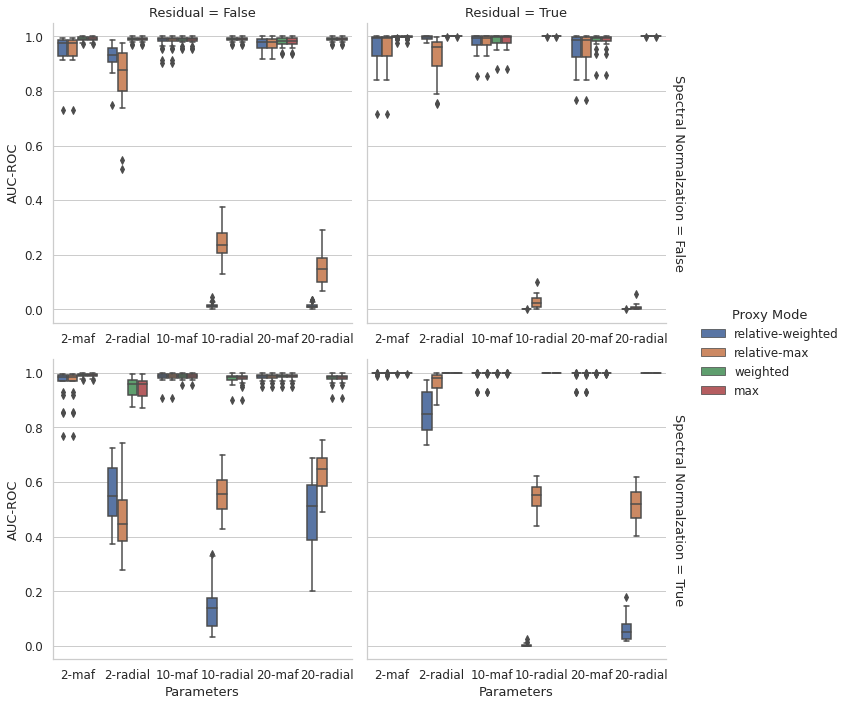

In [181]:
sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
sns.catplot(
    data = df[(df[PROXY] == 'nfpc') & (df[OOD] == ood) & (df[SETTING] == setting) & (df[NO_EDGES] == no_edges)], 
    x=PROXY_PARAMS, y=AUROC,
    col=RESIDUAL, row=SPECTRAL_NORM, kind='box', hue=PROXY_MODE, sharex=False, margin_titles=True
)

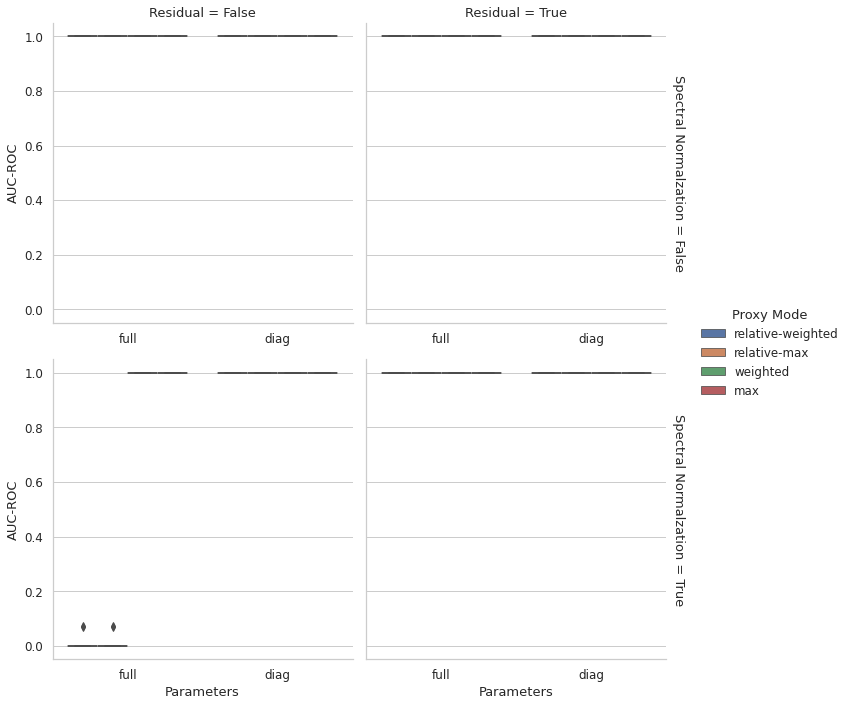

In [178]:
sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
sns.catplot(
    data = df[(df[PROXY] == 'gpc') & (df[OOD] == ood) & (df[SETTING] == setting) & (df[NO_EDGES] == no_edges)],
    x=PROXY_PARAMS, y=AUROC,
    col=RESIDUAL, row=SPECTRAL_NORM, kind='box', hue=PROXY_MODE, sharex=False, margin_titles=True
)

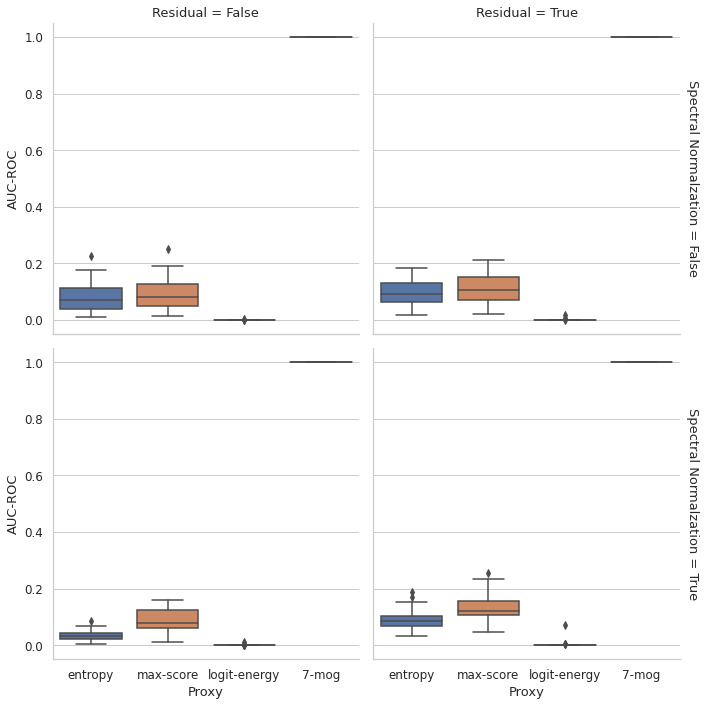

In [179]:
sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
sns.catplot(
    data = df[(df[PROXY] != 'nfpc') & (df[PROXY] != 'gpc') & (df[OOD] == ood) & (df[SETTING] == setting) & (df[NO_EDGES] == no_edges)],
    x=PROXY, y=AUROC,
    col=RESIDUAL, row=SPECTRAL_NORM, kind='box', sharex=True, margin_titles=True
)